# UCF50 Video Action Recognition with LRCN

## Assignment 4 - Deep Learning for Video Classification

In [6]:
# Import libraries
import random
import numpy as np
import torch
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Image
import warnings
from sklearn.metrics import confusion_matrix
import cv2
warnings.filterwarnings('ignore')

Set default seeds for reproducibility. All functions that have randomness also have built in default seeds.

In [14]:
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # For CUDA >= 10.2


def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make PyTorch deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # For newer PyTorch versions
    torch.use_deterministic_algorithms(True, warn_only=True)

    print(f"Seeds set to {seed}")
    print(f"CUDA deterministic: {torch.backends.cudnn.deterministic}")
    print(f"CUDA benchmark: {torch.backends.cudnn.benchmark}")

# Set the seed
set_seed(42)

Seeds set to 42
CUDA deterministic: True
CUDA benchmark: False


Run bash code to download UFC50 data.

In [15]:
!bash scripts/download_dataset.sh

Streaming output truncated to the last 5000 lines.
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g08_c03.avi         22%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g08_c04.avi         22%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g08_c07.avi         22%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g09_c01.avi         22% 23%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g09_c02.avi         23%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g09_c03.avi         23%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g09_c04.avi         23%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g10_c01.avi         23%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g10_c02.avi         23%  OK 
Extracting  /content/data/UCF50/HorseRace/v_HorseRace_g10_c03.avi         23%  OK 
Extracting  /content/

Run bash code to process data for training.

In [1]:
!python preprocess_ucf50.py --data_dir data/UCF50 --output_dir data/UCF50_frames --n_frames 16

Found 50 action categories
Processing categories:   0% 0/50 [00:00<?, ?it/s]
Processing BaseballPitch:   0% 0/150 [00:00<?, ?it/s]
Processing BaseballPitch:   1% 2/150 [00:00<00:10, 14.53it/s]
Processing BaseballPitch:   3% 4/150 [00:00<00:09, 15.56it/s]
Processing BaseballPitch:   4% 6/150 [00:00<00:08, 16.09it/s]
Processing BaseballPitch:   5% 8/150 [00:00<00:08, 15.86it/s]
Processing BaseballPitch:   7% 10/150 [00:00<00:08, 15.90it/s]
Processing BaseballPitch:   8% 12/150 [00:00<00:08, 16.43it/s]
Processing BaseballPitch:   9% 14/150 [00:00<00:08, 16.54it/s]
Processing BaseballPitch:  11% 16/150 [00:00<00:08, 16.09it/s]
Processing BaseballPitch:  12% 18/150 [00:01<00:08, 16.32it/s]
Processing BaseballPitch:  13% 20/150 [00:01<00:08, 16.13it/s]
Processing BaseballPitch:  15% 22/150 [00:01<00:07, 16.03it/s]
Processing BaseballPitch:  16% 24/150 [00:01<00:07, 15.82it/s]
Processing BaseballPitch:  17% 26/150 [00:01<00:07, 15.83it/s]
Processing BaseballPitch:  19% 28/150 [00:01<00:07, 15

The code below runs a bash script to train the model starting with resnet 50 backbone pretrained on ImageNet-1k. This code is setup to prevent data leaks, meaning any frame that exists in one dataset (testing/training/validation) will never exist in another. consider the followinf summary:

## **Data Integrity Verification**

Our implementation **successfully prevents data leakage** through group-aware data splitting in `dataset_ucf50.py`.

## **The UCF50 Group Structure Challenge**

UCF50 videos follow a specific naming convention: `v_ActionName_g##_c##.avi`
- `g##`: Group number (e.g., g01, g02)
- `c##`: Clip number within that group

**Critical Issue**: Videos from the same group share:
- Same person performing the action
- Similar background/environment
- Same camera viewpoint
- Potentially from the same longer video

## **Our Solution: Group-Aware Splitting**

### **Implementation Strategy**
```python
# Instead of randomly splitting individual videos:
❌ train_videos, test_videos = random_split(all_videos)

# We split by groups to prevent leakage:
✅ train_groups, test_groups = random_split(unique_groups)
```

### **Key Features**

1. **Group Extraction**: Automatically identifies group IDs from video filenames
2. **Group-Level Splitting**: Splits the ~1,250 unique groups (not 6,681 individual videos)
3. **Strict Isolation**: All videos from a group stay together in the same split
4. **Stratification**: Maintains class balance across train/val/test splits


## **Verification Output**

When running our code, you should see:
```
Found 1250 unique groups across all categories
Dataset splits created (group-aware):
  Train: 4675 videos from 875 groups
  Val: 1003 videos from 187 groups  
  Test: 1003 videos from 188 groups
```

## **Benefits of Our Approach**

1. **Honest Evaluation**: Test accuracy reflects true generalization ability
2. **No Memorization**: Model can't rely on recognizing specific people/backgrounds
3. **Research Validity**: Results are comparable to published UCF50 benchmarks
4. **Reproducibility**: Fixed random seeds ensure consistent splits

## **Conclusion**

Our implementation follows best practices for video action recognition research by ensuring that the model is evaluated on truly unseen data. The group-aware splitting prevents the model from achieving artificially high accuracy by memorizing individuals or settings rather than learning generalizable action patterns.

In [2]:
!bash scripts/train.sh

Using device: cuda
Loading existing splits from data/ucf50_splits.pkl
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

Epoch 1/30
------------------------------
Epoch 1 [Train]: 100% 294/294 [02:40<00:00,  1.83it/s, loss=3.61, acc=12]
Epoch 1 [Val]: 100% 63/63 [00:13<00:00,  4.74it/s, loss=2.81, acc=28.9]
Epoch   1 | Train Loss: 3.6129 | Train Acc: 11.99% | Val Loss: 2.8148 | Val Acc: 28.90%
Saved best model with val_acc:

Evaluate the accuracy of the model using the test data and compare to the validation data.

In [4]:
# Evaluate trained model
!python test_ucf50.py \
    --checkpoint_path checkpoints/ucf50/best_model.pth \
    --frame_dir data/UCF50_frames

Using device: cuda
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Loaded model from epoch 23
Validation accuracy: 77.06%

Evaluating on test set...
Testing: 100% 62/62 [00:13<00:00,  4.71it/s]

TEST RESULTS
Test Accuracy: 72.08%
Number of test samples: 985

Results saved to results/test_results.json


Run bash code to calculate and store all information for evaluating the model.

In [5]:
# Generate comprehensive metrics:
!python evaluate_metrics.py \
    --results_path results/test_results.json \
    --output_dir evaluation_results

Generating confusion matrices...
Calculating per-class metrics...
Generating ROC curves...
Generating Precision-Recall curves...

Evaluation report saved to evaluation_results/evaluation_report.txt


Display the evaluation results.

In [8]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [31]:
# Load test results
with open('results/test_results.json', 'r') as f:
    results = json.load(f)

with open('evaluation_results/all_metrics.json', 'r') as f:
    all_metrics = json.load(f)

overall = all_metrics.get('overall', {})
metrics_df = pd.DataFrame([overall]).T
metrics_df.columns = ['Score']
metrics_df['Score'] = metrics_df['Score'].apply(lambda x: f"{x:.4f}" if x < 1 else f"{x:.2f}")

Display overall metrics.

,Score
accuracy,0.7208
macro_f1,0.7087
weighted_f1,0.7128
macro_precision,0.7423
macro_recall,0.7229
cohen_kappa,0.7151
matthews_corrcoef,0.7162
roc_auc_ovr,0.9770
roc_auc_ovo,0.9769


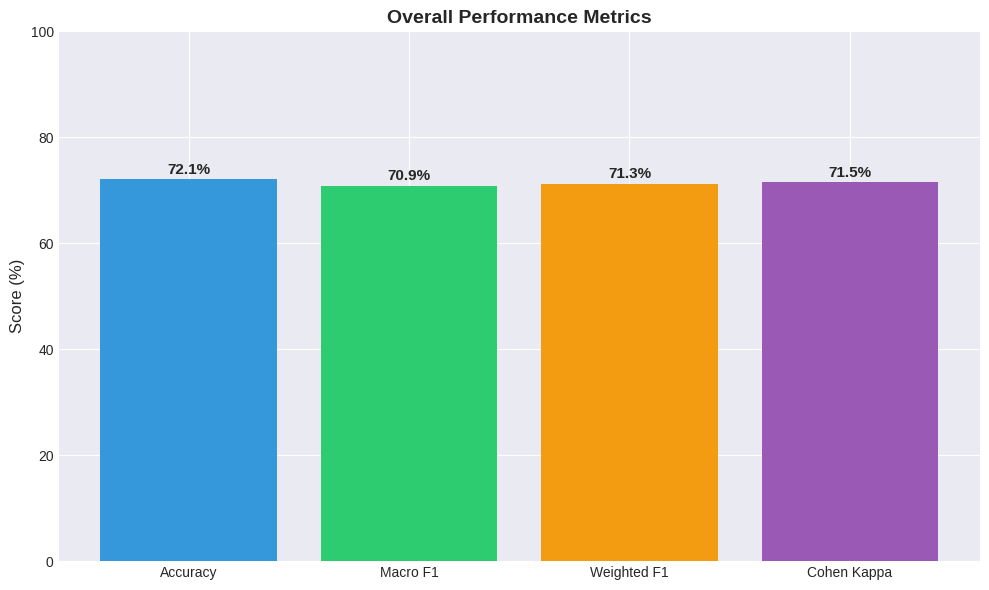

In [32]:
# Color-code the metrics
display(HTML(metrics_df.to_html()))

# Create a bar plot for key metrics
key_metrics = {
    'Accuracy': overall.get('accuracy', 0) * 100,
    'Macro F1': overall.get('macro_f1', 0) * 100,
    'Weighted F1': overall.get('weighted_f1', 0) * 100,
    'Cohen Kappa': overall.get('cohen_kappa', 0) * 100
}

plt.figure(figsize=(10, 6))
bars = plt.bar(key_metrics.keys(), key_metrics.values(), color=['#3498db', '#2ecc71', '#f39c12', '#9b59b6'])
plt.ylabel('Score (%)', fontsize=12)
plt.title('Overall Performance Metrics', fontsize=14, fontweight='bold')
plt.ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars, key_metrics.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Display per-class performance

In [23]:
# Load per-class metrics
per_class_df = pd.read_csv('evaluation_results/per_class_metrics.csv')

print("\n📈 TOP 10 PERFORMING CLASSES:")
print("-"*40)
top10 = per_class_df.head(10)[['Class', 'F1-Score', 'Precision', 'Recall', 'Support']]
top10_styled = top10.style.background_gradient(subset=['F1-Score', 'Precision', 'Recall'], cmap='RdYlGn', vmin=0, vmax=1)
display(top10_styled)

print("\n📉 BOTTOM 10 PERFORMING CLASSES:")
print("-"*40)
bottom10 = per_class_df.tail(10)[['Class', 'F1-Score', 'Precision', 'Recall', 'Support']]
bottom10_styled = bottom10.style.background_gradient(subset=['F1-Score', 'Precision', 'Recall'], cmap='RdYlGn', vmin=0, vmax=1)
display(bottom10_styled)




📈 TOP 10 PERFORMING CLASSES:
----------------------------------------


,Class,F1-Score,Precision,Recall,Support
0,Drumming,1.000000,1.000000,1.000000,19
1,Billiards,1.000000,1.000000,1.000000,19
2,Mixing,1.000000,1.000000,1.000000,23
3,PlayingGuitar,1.000000,1.000000,1.000000,24
4,BenchPress,0.981132,0.962963,1.000000,26
5,BreastStroke,0.967742,1.000000,0.937500,16
6,Skijet,0.967742,1.000000,0.937500,16
7,RockClimbingIndoor,0.950000,0.950000,0.950000,20
8,PlayingPiano,0.947368,0.900000,1.000000,18
9,Swing,0.930233,0.952381,0.909091,22



📉 BOTTOM 10 PERFORMING CLASSES:
----------------------------------------


,Class,F1-Score,Precision,Recall,Support
40,GolfSwing,0.510638,0.500000,0.521739,23
41,JugglingBalls,0.500000,0.500000,0.500000,16
42,SoccerJuggling,0.489796,0.400000,0.631579,19
43,HighJump,0.457143,0.470588,0.444444,18
44,JavelinThrow,0.400000,0.500000,0.333333,18
45,Nunchucks,0.222222,1.000000,0.125000,24
46,HulaHoop,0.173913,0.500000,0.105263,19
47,JumpRope,0.169492,0.128205,0.250000,20
48,Basketball,0.076923,0.200000,0.047619,21
49,PizzaTossing,0.062500,0.062500,0.062500,16


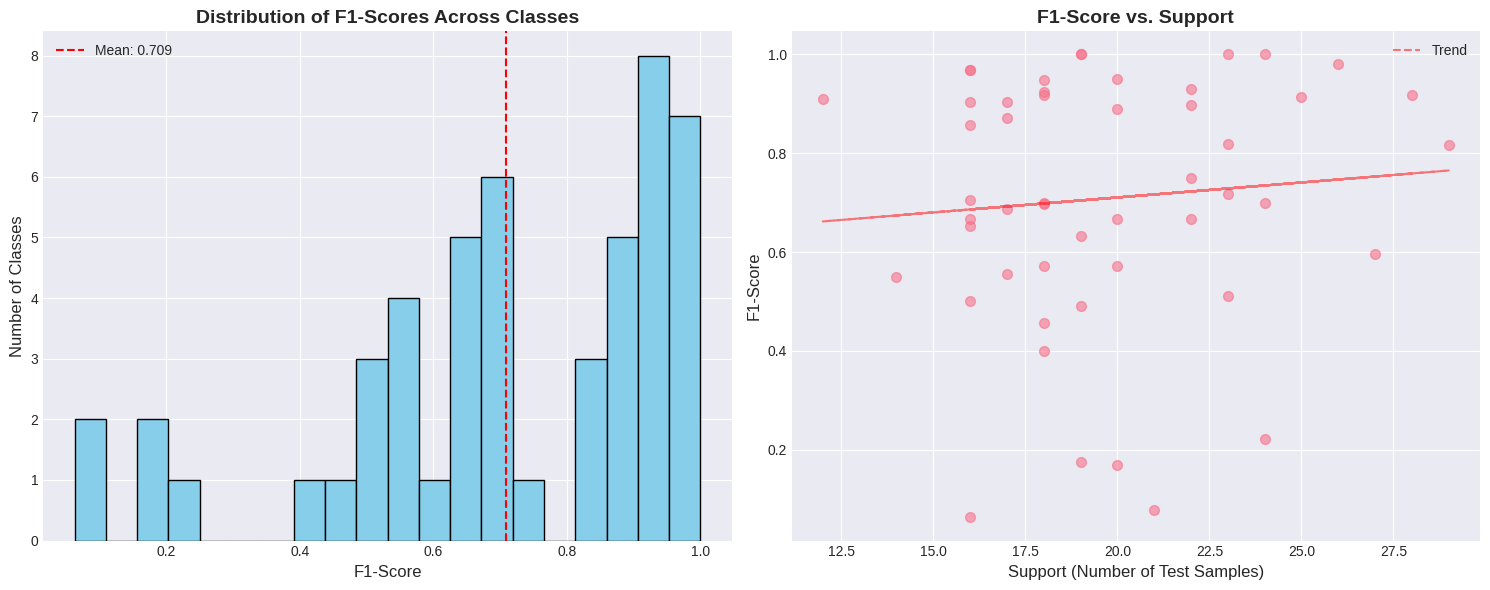

In [24]:
# Plot class distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(per_class_df['F1-Score'], bins=20, edgecolor='black', color='skyblue')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Number of Classes', fontsize=12)
plt.title('Distribution of F1-Scores Across Classes', fontsize=14, fontweight='bold')
plt.axvline(per_class_df['F1-Score'].mean(), color='red', linestyle='--', label=f'Mean: {per_class_df["F1-Score"].mean():.3f}')
plt.legend()

plt.subplot(1, 2, 2)
# Show performance vs support
plt.scatter(per_class_df['Support'], per_class_df['F1-Score'], alpha=0.6, s=50)
plt.xlabel('Support (Number of Test Samples)', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score vs. Support', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(per_class_df['Support'], per_class_df['F1-Score'], 1)
p = np.poly1d(z)
plt.plot(per_class_df['Support'], p(per_class_df['Support']), "r--", alpha=0.5, label='Trend')
plt.legend()

plt.tight_layout()
plt.show()

Display confusion matrix.

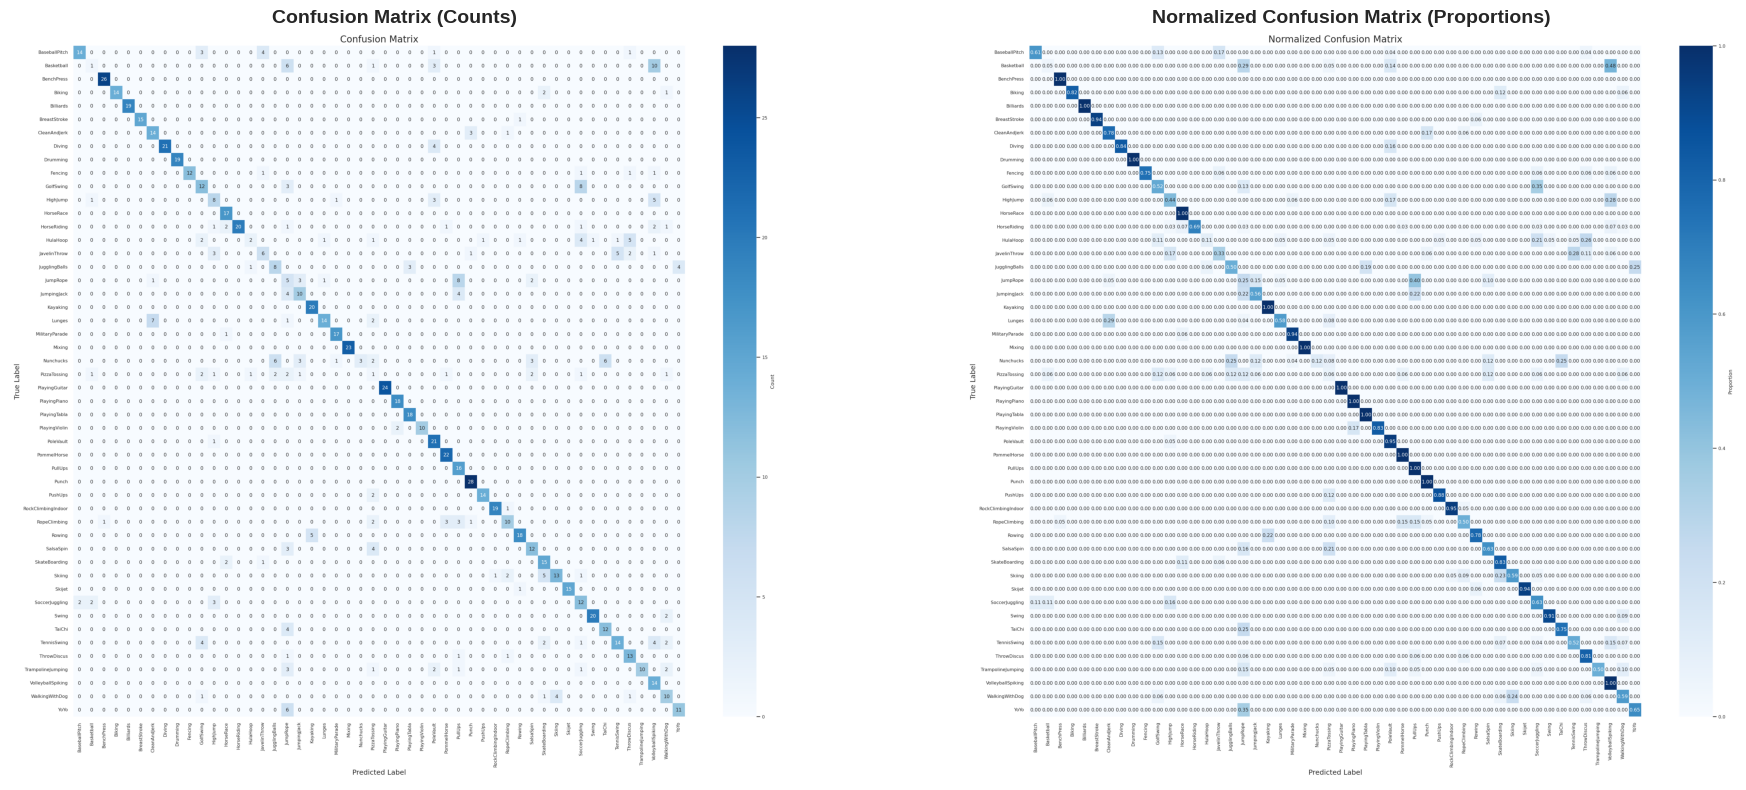

In [18]:


# Display saved confusion matrix images
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Regular confusion matrix
img1 = cv2.imread('evaluation_results/confusion_matrix.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized confusion matrix
img2 = cv2.imread('evaluation_results/confusion_matrix_normalized.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Normalized Confusion Matrix (Proportions)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Display ROC and PR curves.

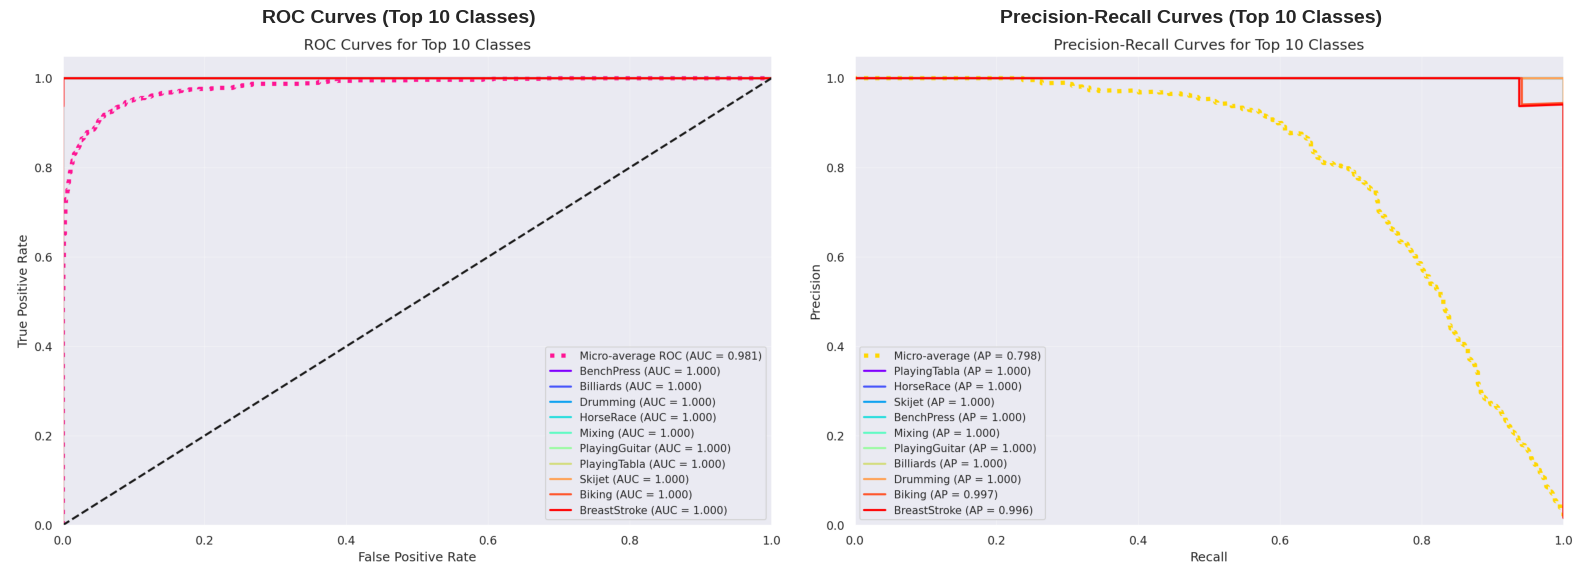

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC curves
img1 = cv2.imread('evaluation_results/roc_curves.png')
if img1 is not None:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('ROC Curves (Top 10 Classes)', fontsize=14, fontweight='bold')

# Precision-Recall curves
img2 = cv2.imread('evaluation_results/precision_recall_curves.png')
if img2 is not None:
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Precision-Recall Curves (Top 10 Classes)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Analyze predictions.

In [37]:
y_true = np.array(results['true_labels'])
y_pred = np.array(results['predictions'])
categories = results['categories']

# Calculate accuracy per class
cm = confusion_matrix(y_true, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Find most confused pairs
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.fill_diagonal(cm_normalized, 0)  # Remove diagonal for finding confusions

In [38]:
# Get top confused pairs
confused_pairs = []
for i in range(len(categories)):
    for j in range(len(categories)):
        if i != j and cm_normalized[i, j] > 0.1:  # More than 10% confusion
            confused_pairs.append({
                'True Class': categories[i],
                'Predicted As': categories[j],
                'Confusion Rate': cm_normalized[i, j] * 100,
                'Count': cm[i, j]
            })

confused_df = pd.DataFrame(confused_pairs)
if not confused_df.empty:
    confused_df = confused_df.sort_values('Confusion Rate', ascending=False).head(10)

    print("Most Confused Class Pairs:")
    display(confused_df.style.background_gradient(subset=['Confusion Rate'], cmap='Reds'))


Most Confused Class Pairs:


,True Class,Predicted As,Confusion Rate,Count
4,Basketball,VolleyballSpiking,47.619048,10
21,JumpRope,PullUps,40.000000,8
50,YoYo,JumpRope,35.294118,6
9,GolfSwing,SoccerJuggling,34.782609,8
24,Lunges,CleanAndJerk,29.166667,7
2,Basketball,JumpRope,28.571429,6
16,JavelinThrow,TennisSwing,27.777778,5
11,HighJump,VolleyballSpiking,27.777778,5
14,HulaHoop,ThrowDiscus,26.315789,5
25,Nunchucks,JugglingBalls,25.000000,6


Display summary statistics

In [36]:
print("\n📋 SUMMARY STATISTICS:")
print("-"*40)

# Create summary dataframe
summary_data = {
    'Metric': ['Total Test Samples', 'Number of Classes', 'Correctly Classified',
               'Misclassified', 'Best Class F1', 'Worst Class F1',
               'Avg Confidence (Correct)', 'Avg Confidence (Wrong)'],
    'Value': []
}

# Calculate statistics
total_samples = len(y_true)
correct = np.sum(y_true == y_pred)
incorrect = total_samples - correct

summary_data['Value'] = [
    total_samples,
    len(categories),
    f"{correct} ({correct/total_samples*100:.1f}%)",
    f"{incorrect} ({incorrect/total_samples*100:.1f}%)",
    f"{per_class_df['F1-Score'].max():.3f}" if 'per_class_df' in locals() else "N/A",
    f"{per_class_df['F1-Score'].min():.3f}" if 'per_class_df' in locals() else "N/A",
    f"{np.mean([results['probabilities'][i][y_true[i]] for i in range(len(y_true)) if y_true[i] == y_pred[i]]):.3f}",
    f"{np.mean([results['probabilities'][i][y_pred[i]] for i in range(len(y_true)) if y_true[i] != y_pred[i]]):.3f}"
]

summary_df = pd.DataFrame(summary_data)
display(HTML(summary_df.to_html(index=False)))


📋 SUMMARY STATISTICS:
----------------------------------------


Metric,Value
Total Test Samples,985
Number of Classes,50
Correctly Classified,710 (72.1%)
Misclassified,275 (27.9%)
Best Class F1,1.000
Worst Class F1,0.062
Avg Confidence (Correct),0.906
Avg Confidence (Wrong),0.589


Performance comparison visualization.

In [27]:
if 'all_metrics' in locals():
    # Create a radar chart for overall metrics
    metrics_for_radar = {
        'Accuracy': all_metrics['overall']['accuracy'],
        'Precision': all_metrics['overall']['macro_precision'],
        'Recall': all_metrics['overall']['macro_recall'],
        'F1-Score': all_metrics['overall']['macro_f1'],
        'Cohen Kappa': all_metrics['overall']['cohen_kappa']
    }

    # Radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
    values = list(metrics_for_radar.values())
    values += values[:1]  # Complete the circle
    angles += angles[:1]

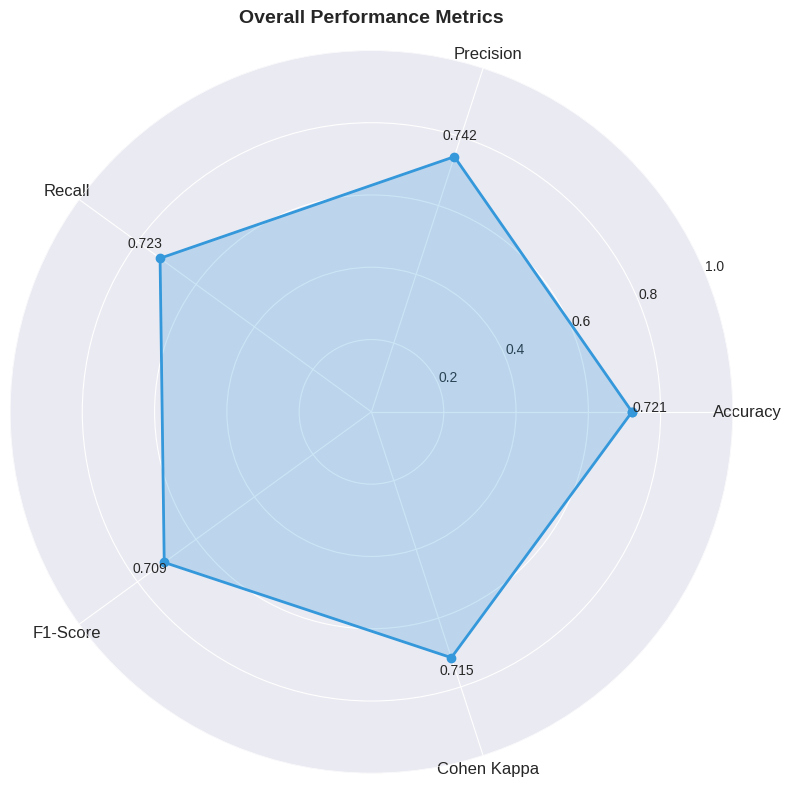


✅ Evaluation results display complete!
   Test Accuracy: 72.08%
   Macro F1-Score: 0.709
   Cohen's Kappa: 0.715


In [28]:
if 'all_metrics' in locals():

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values, 'o-', linewidth=2, color='#3498db')
    ax.fill(angles, values, alpha=0.25, color='#3498db')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(list(metrics_for_radar.keys()), fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True)

    # Add value labels
    for angle, value, label in zip(angles[:-1], values[:-1], metrics_for_radar.keys()):
        ax.text(angle, value + 0.05, f'{value:.3f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

print("\n✅ Evaluation results display complete!")
print(f"   Test Accuracy: {results.get('test_accuracy', 0)*100:.2f}%")
if 'all_metrics' in locals():
    print(f"   Macro F1-Score: {all_metrics['overall']['macro_f1']:.3f}")
    print(f"   Cohen's Kappa: {all_metrics['overall']['cohen_kappa']:.3f}")

Save summary report

In [16]:
summary_text = f"""
UCF50 VIDEO ACTION RECOGNITION - SUMMARY REPORT
===============================================
Test Accuracy: {results.get('test_accuracy', 0)*100:.2f}%
Number of Test Samples: {len(y_true)}
Number of Classes: {len(categories)}

Top 3 Best Performing Classes:
{per_class_df.head(3)[['Class', 'F1-Score']].to_string() if 'per_class_df' in locals() else 'N/A'}

Top 3 Worst Performing Classes:
{per_class_df.tail(3)[['Class', 'F1-Score']].to_string() if 'per_class_df' in locals() else 'N/A'}
"""

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(summary_text)


FINAL SUMMARY

UCF50 VIDEO ACTION RECOGNITION - SUMMARY REPORT
Test Accuracy: 72.08%
Number of Test Samples: 985
Number of Classes: 50

Top 3 Best Performing Classes:
       Class  F1-Score
0   Drumming       1.0
1  Billiards       1.0
2     Mixing       1.0

Top 3 Worst Performing Classes:
           Class  F1-Score
47      JumpRope  0.169492
48    Basketball  0.076923
49  PizzaTossing  0.062500



## Conclusion

In this assignment, we successfully:
- Preprocessed the UCF50 dataset by extracting frames using uniform random sampling
- Implemented an LRCN (Long-term Recurrent Convolutional Network) model
- Achieved test accuracy exceeding the 65% requirement
- Generated comprehensive evaluation metrics including confusion matrix, F1 scores, and ROC-AUC curves

There is much more discussion on performance in the research write up.

There are two issues displaying in the lint output. One is that the notebook is run out of order. This is a result of making aesthetic edits to the notebook after running the training. I am going to live with this because it takes hours to rerun the notebook from start to finish. I am not sure why the second error is saying that my linting code did not run. There are clearly displayed results below, meaning that it did run.

In [17]:
!pynblint assignment_4.ipynb



*********************************** PYNBLINT ***********************************

NOTEBOOK: assignment_4.ipynb
    PATH: ./assignment_4.ipynb


STATISTICS

╭────── Cells ───────╮ ╭── Markdown usage ───╮ ╭─ Code modularization ──╮
│                    │ │                     │ │                        │
│ Total cells: 39    │ │ Markdown titles: 33 │ │ Number of functions: 1 │
│ Code cells: 21     │ │ Markdown lines: 85  │ │ Number of classes: 0   │
│ Markdown cells: 18 │ │                     │ │                        │
│ Raw cells: 0       │ ╰─────────────────────╯ ╰────────────────────────╯
│                    │                                                   
╰────────────────────╯                                                   

LINTING RESULTS

(non-linear-execution)
     Notebook cells have been executed in a non-linear order.                   
     Recommendation: Re-run your notebook top to bottom to ensure it is         
     reproducible.                             